# *GOOGLE STOCK ANALYSIS*

In [1]:
'''importing essential modules'''
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
from matplotlib import warnings
import yfinance as yf
from yahoofinancials import YahooFinancials

# Import the backtrader platform
import backtrader as bt


In [2]:
feed= yf.download('GOOG', 
                      start='2018-08-01', 
                      end='2021-12-31', 
                      progress=False,)
feed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-31,61.000500,61.379398,60.279999,60.862999,60.862999,32894000
2018-08-01,61.400002,61.673500,60.510502,61.000500,61.000500,31344000
2018-08-02,60.294998,61.493999,60.239498,61.307499,61.307499,30626000
2018-08-03,61.480999,61.500000,60.752998,61.185501,61.185501,21792000
2018-08-06,61.250000,61.304401,60.789848,61.238499,61.238499,21634000
...,...,...,...,...,...,...
2021-12-23,147.089493,148.572601,146.950851,147.142502,147.142502,13818000
2021-12-27,147.463501,148.426498,147.250000,148.063995,148.063995,13256000
2021-12-28,148.374496,148.374496,145.935501,146.447998,146.447998,18624000


In [3]:
data=bt.feeds.PandasData(dataname=feed)

# SIMPLE MOVING AVERAGE

In [4]:
'''Create a Strategy'''
class SmaStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )
    
    
    '''This is defined for logging purposes'''
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    
    ''' Here, we defined the objects that we would like to keep track of, for example, close price, order, buy price, 
    commission, indicators such as SMA, and so on.'''
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)
        
        
    ''' This is defined for reporting the status of the order (position)'''
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
        
        
    ''' This is defined for reporting the results of trades (after the positions are closed).'''
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    ''' This is the place containing the trading strategy's logic.'''
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


In [5]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(SmaStrategy)

  

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

In [6]:
 # Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
cerebro.run()

    # Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-08-20, Close, 60.39
2018-08-21, Close, 60.08
2018-08-22, Close, 60.37
2018-08-23, Close, 60.27
2018-08-24, Close, 61.03
2018-08-27, Close, 62.09
2018-08-27, BUY CREATE, 62.09
2018-08-28, BUY EXECUTED, Price: 62.06, Cost: 620.64, Comm 0.00
2018-08-28, Close, 61.56
2018-08-29, Close, 62.47
2018-08-30, Close, 61.96
2018-08-31, Close, 60.91
2018-08-31, SELL CREATE, 60.91
2018-09-04, SELL EXECUTED, Price: 60.21, Cost: 620.64, Comm 0.00
2018-09-04, OPERATION PROFIT, GROSS -18.51, NET -18.51
2018-09-04, Close, 59.85
2018-09-05, Close, 59.32
2018-09-06, Close, 58.57
2018-09-07, Close, 58.24
2018-09-10, Close, 58.23
2018-09-11, Close, 58.87
2018-09-12, Close, 58.14
2018-09-13, Close, 58.77
2018-09-14, Close, 58.63
2018-09-17, Close, 57.80
2018-09-18, Close, 58.06
2018-09-19, Close, 58.55
2018-09-20, Close, 59.34
2018-09-20, BUY CREATE, 59.34
2018-09-21, BUY EXECUTED, Price: 59.60, Cost: 596.00, Comm 0.00
2018-09-21, Close, 58.30
2018-09-21, SELL CREATE, 5

<IPython.core.display.Javascript object>


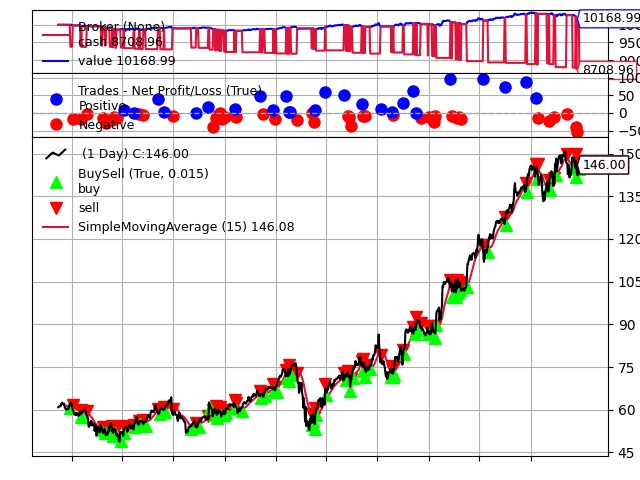

[[<Figure size 640x480 with 3 Axes>]]

In [7]:
cerebro.plot(iplot=True, volume=False)

# Bollinger Bands

In [8]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),('devfactor', 2.0),)
    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0],
        period=self.p.period,
        devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0],
        self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0],
        self.b_band.lines.top)
        
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price:{order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price:{order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
        elif order.status in [order.Canceled, order.Margin,order.Rejected]:
            self.log('Order Failed')
        self.order = None

    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f},Net: {trade.pnlcomm:.2f}')
    
    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                size = int(self.broker.getcash(), self.datas[0].open)
                self.log(f'BUY CREATED --- Size: {size}, Cash:{self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close:{self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                self.log(f'SELL CREATED --- Size:{self.position.size}')
                self.sell(size=self.position.size)
            
            


In [9]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(BBand_Strategy)

  

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

In [10]:
 # Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
cerebro.run()

    # Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00


<IPython.core.display.Javascript object>


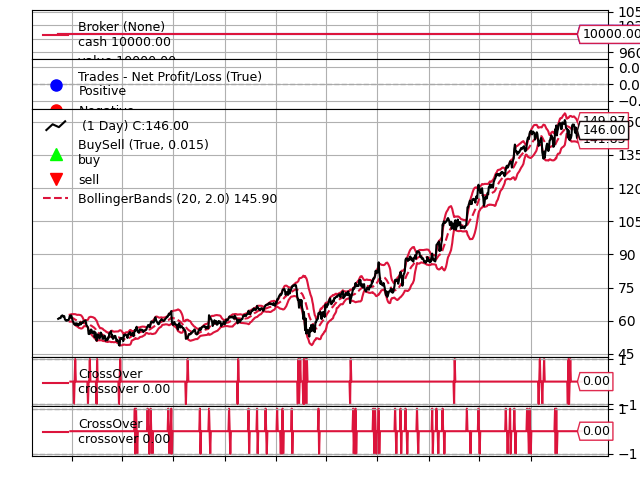

[[<Figure size 640x480 with 5 Axes>]]

In [11]:
cerebro.plot(iplot=True, volume=False)

# RELATIVE SIMPLE INDEX

In [12]:
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70,rsi_lower=30, rsi_mid=50)
    def __init__(self):
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,upperband=self.p.rsi_upper,lowerband=self.p.rsi_lower)
        bt.talib.RSI(self.data, plotname='TA_RSI')
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower,plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi >self.p.rsi_mid))
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper,plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

In [13]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(RsiSignalStrategy)

  

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

In [14]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000.00
Final Portfolio Value: 710.79


<IPython.core.display.Javascript object>


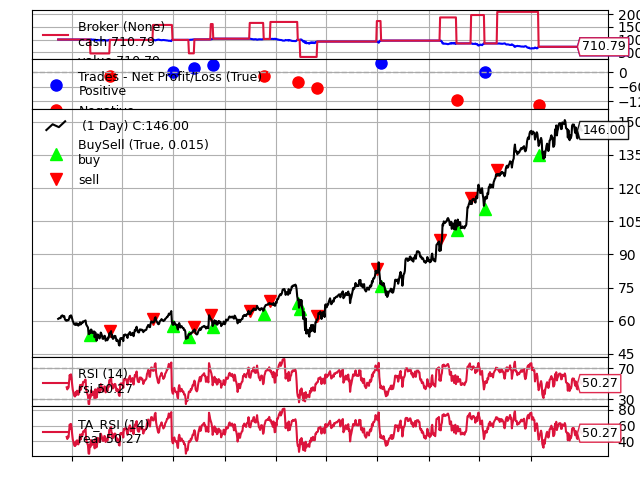

[[<Figure size 640x480 with 5 Axes>]]

In [15]:
cerebro.plot(iplot=True, volume=False)